## Importing the required libraries and loading data

In [1]:
!pip install -U -q tensorflow tensorflow_datasets
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 42.3 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be DOWNGRADED:
  libcudnn8
0 upgraded, 0 newly installed, 1 downgraded, 1 to remove and 22 not upgraded.
Need to get 430 MB of archives.
After this operation, 1,153 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 430 MB in 11s (40.4 MB/s)
(Reading database ... 122518 files and directories currently installed.)
Removing libcudnn8-dev (8.7.0.84-1+cuda11.8) ...
update-alternatives: removing manually selected alternative - switching libcudnn to auto mode
dpkg: warning: downgrading libcudnn8 fro

In [2]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
from sklearn.model_selection import train_test_split

import os
import pathlib
import librosa
import json

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [3]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

182082353/182082353 [==============================] - 1s 0us/step


In [4]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['right' 'up' 'no' 'down' 'yes' 'left' 'go' 'stop']


## Pre-processing of data

In [5]:
JSON_PATH = "data.json"
SAMPLES_TO_CONSIDER = 22050 

data = {
    "mapping": [],
    "labels": [],
    "MFCCs": [],
    "files": []
}

for i, (dirpath, dirnames, filenames) in enumerate(os.walk(DATASET_PATH)):

    if dirpath is not DATASET_PATH:

        label = dirpath.split("/")[-1]
        data["mapping"].append(label)
        print("\nProcessing: '{}'".format(label))

        for f in filenames:
            file_path = os.path.join(dirpath, f)

            signal, sample_rate = librosa.load(file_path)

            if len(signal) >= SAMPLES_TO_CONSIDER:

                signal = signal[:SAMPLES_TO_CONSIDER]

                num_mfcc = 13
                n_fft = 2048
                hop_length = 512
                MFCCs = librosa.feature.mfcc(y=signal, n_mfcc=num_mfcc, hop_length=hop_length, n_fft=n_fft)

                data["MFCCs"].append(MFCCs.T.tolist())
                data["labels"].append(i-1)
                data["files"].append(file_path)
                print("{}: {}".format(file_path, i-1))

# save data in json file
with open(JSON_PATH, "w") as fp:
    json.dump(data, fp, indent=4)


Streaming output truncated to the last 5000 lines.
data/mini_speech_commands/no/257251e0_nohash_0.wav: 2
data/mini_speech_commands/no/2bfe70ef_nohash_0.wav: 2
data/mini_speech_commands/no/9712cce0_nohash_0.wav: 2
data/mini_speech_commands/no/8830e17f_nohash_3.wav: 2
data/mini_speech_commands/no/6c0f6493_nohash_2.wav: 2
data/mini_speech_commands/no/079d1020_nohash_0.wav: 2
data/mini_speech_commands/no/5ff3f9a1_nohash_0.wav: 2
data/mini_speech_commands/no/270bfa52_nohash_0.wav: 2
data/mini_speech_commands/no/8dc26a15_nohash_0.wav: 2
data/mini_speech_commands/no/6736bc64_nohash_1.wav: 2
data/mini_speech_commands/no/4c432947_nohash_1.wav: 2
data/mini_speech_commands/no/421ed23f_nohash_0.wav: 2
data/mini_speech_commands/no/bc065a17_nohash_0.wav: 2
data/mini_speech_commands/no/6a014b29_nohash_0.wav: 2
data/mini_speech_commands/no/2bdbe5f7_nohash_3.wav: 2
data/mini_speech_commands/no/37e8db82_nohash_0.wav: 2
data/mini_speech_commands/no/ac652c60_nohash_0.wav: 2
data/mini_speech_commands/no/b8

## Training and test of data

In [6]:
DATA_PATH = "data.json"

# generate train, validation and test sets        
def prepare_dataset(data_path, test_size=0.2, validation_size=0.2):
    # load dataset
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["MFCCs"])
    y = np.array(data["labels"])
    print("Training sets loaded!")


    # create train, validation, test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to nd array
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]

    return X_train, y_train, X_validation, y_validation, X_test, y_test

X_train, y_train, X_validation, y_validation, X_test, y_test = prepare_dataset(DATA_PATH)

Training sets loaded!


## Model Training

### CNN Model with 3 Layers

In [7]:
# create network

#parameters 
LEARNING_RATE = 0.001


def build_model(input_shape, loss="sparse_categorical_crossentropy", learning_rate=0.0001):
    
    # build network architecture using convolutional layers
    model = tf.keras.models.Sequential()

    # 1st conv layer
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))

    # 2nd conv layer
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))

    # 3rd conv layer
    model.add(tf.keras.layers.Conv2D(32, (2, 2), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2), padding='same'))

    # flatten output and feed into dense layer
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    tf.keras.layers.Dropout(0.3)

    # softmax output layer
    model.add(tf.keras.layers.Dense(8, activation='softmax'))

    optimiser = tf.optimizers.Adam(learning_rate=learning_rate)

    # compile model
    model.compile(optimizer=optimiser,
                  loss=loss,
                  metrics=["accuracy"])

    # print model parameters on console
    model.summary()

    return model

input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape, learning_rate=LEARNING_RATE)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 42, 11, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 42, 11, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 21, 6, 64)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 19, 4, 32)         18464     
                                                                 
 batch_normalization_1 (Batc  (None, 19, 4, 32)        128       
 hNormalization)                                                 
                                                        

In [8]:
EPOCHS = 40
BATCH_SIZE = 16
PATIENCE = 5

def train(model, epochs, batch_size, patience, X_train, y_train, X_validation, y_validation):
    earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="accuracy", min_delta=0.001, patience=patience)

    # train model
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_validation, y_validation),
                        callbacks=[earlystop_callback])
    return history




# train network
history = train(model, EPOCHS, BATCH_SIZE, PATIENCE, X_train, y_train, X_validation, y_validation)

Epoch 1/40
288/288 [==============================] - 12s 34ms/step - loss: 1.4483 - accuracy: 0.5180 - val_loss: 1.1358 - val_accuracy: 0.6214
Epoch 2/40
288/288 [==============================] - 10s 34ms/step - loss: 0.7608 - accuracy: 0.7592 - val_loss: 0.8827 - val_accuracy: 0.7198
Epoch 3/40
288/288 [==============================] - 8s 27ms/step - loss: 0.5885 - accuracy: 0.8247 - val_loss: 0.6298 - val_accuracy: 0.8050
Epoch 4/40
288/288 [==============================] - 10s 34ms/step - loss: 0.4946 - accuracy: 0.8570 - val_loss: 0.5795 - val_accuracy: 0.8207
Epoch 5/40
288/288 [==============================] - 8s 29ms/step - loss: 0.4312 - accuracy: 0.8803 - val_loss: 0.5861 - val_accuracy: 0.8277
Epoch 6/40
288/288 [==============================] - 9s 31ms/step - loss: 0.3667 - accuracy: 0.9031 - val_loss: 0.4917 - val_accuracy: 0.8573
Epoch 7/40
288/288 [==============================] - 10s 34ms/step - loss: 0.3397 - accuracy: 0.9101 - val_loss: 0.4862 - val_accuracy: 0.

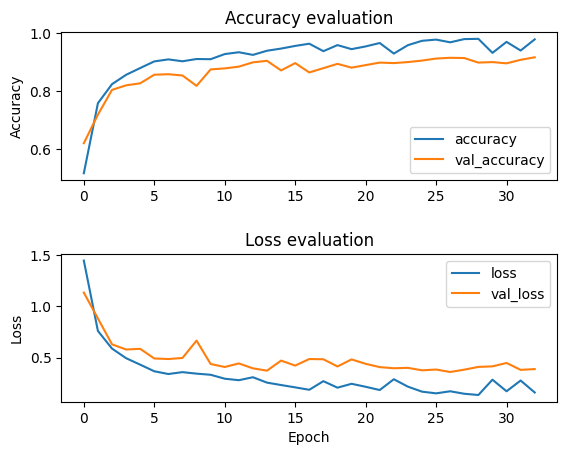

In [9]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs

    :param history: Training history of model
    :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy subplot
    axs[0].plot(history.history["accuracy"], label="accuracy")
    axs[0].plot(history.history['val_accuracy'], label="val_accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy evaluation")

    # create loss subplot
    axs[1].plot(history.history["loss"], label="loss")
    axs[1].plot(history.history['val_loss'], label="val_loss")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Loss")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Loss evaluation")

    plt.subplots_adjust(hspace=0.5)  # adjust spacing between subplots

    plt.show()



# plot accuracy/loss for training/validation set as a function of the epochs
plot_history(history)

In [10]:
from sklearn.metrics import confusion_matrix

# Predict on the test data
y_pred = model.predict(X_test)

# Convert the predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)

print(cm)


45/45 [==============================] - 1s 10ms/step
[[153   1   0   2   1   3   1   1]
 [  4 149   2   2   3   1   0   2]
 [  1   0 154   3   1   3   7   0]
 [  1   1  22 131   3   2   8   1]
 [  2   2   2   0 200   4   0   1]
 [  4   2   5   1   3 175   2   0]
 [  1   6  12   6   2   2 151   0]
 [  1  10   1   3   2   2   6 165]]


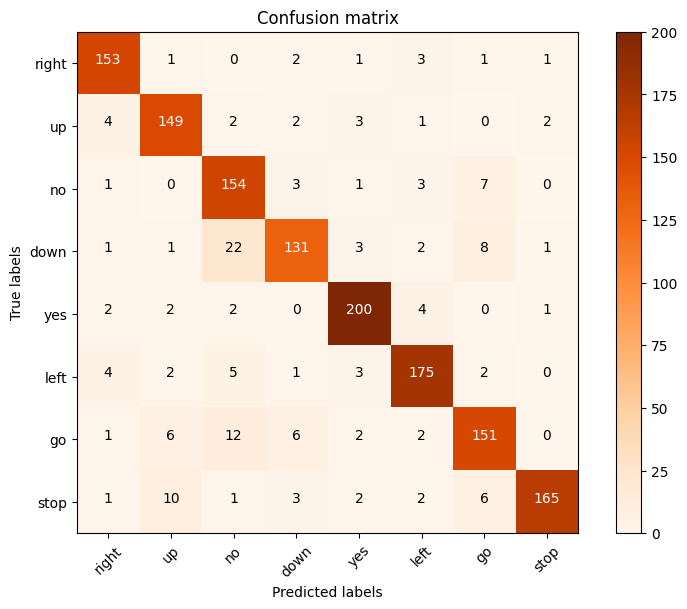

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=False):
     
    if cmap is None:
        cmap = plt.get_cmap('Oranges')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylim(len(target_names)-0.5, -0.5)
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.savefig(title + '.png', dpi=500, bbox_inches = 'tight')
    plt.show()
    
target_names = ['right', 'up', 'no', 'down', 'yes', 'left', 'go', 'stop']
plot_confusion_matrix(cm, target_names)

In [ ]:
# evaluate network on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print("\nTest loss: {}, test accuracy: {}".format(test_loss, 100*test_acc))


45/45 [==============================] - 1s 18ms/step - loss: 0.4065 - accuracy: 0.8962

Test loss: 0.4064900577068329, test accuracy: 89.62395787239075


### CNN model with 2 layers

In [ ]:
# create network

#parameters 
LEARNING_RATE = 0.001


def build_model2(input_shape, loss="sparse_categorical_crossentropy", learning_rate=0.0001):
    
    # build network architecture using convolutional layers
    model = tf.keras.models.Sequential()

    # 1st conv layer
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))

    # 2nd conv layer
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))

    # flatten output and feed into dense layer
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    tf.keras.layers.Dropout(0.3)

    # softmax output layer
    model.add(tf.keras.layers.Dense(8, activation='softmax'))

    optimiser = tf.optimizers.Adam(learning_rate=learning_rate)

    # compile model
    model.compile(optimizer=optimiser,
                  loss=loss,
                  metrics=["accuracy"])

    # print model parameters on console
    model.summary()

    return model

input_shape = (X_train.shape[1], X_train.shape[2], 1)
model_with_2layers = build_model2(input_shape, learning_rate=LEARNING_RATE)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 42, 11, 64)        640       
                                                                 
 batch_normalization_5 (Batc  (None, 42, 11, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 21, 6, 64)        0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 19, 4, 32)         18464     
                                                                 
 batch_normalization_6 (Batc  (None, 19, 4, 32)        128       
 hNormalization)                                                 
                                                      

In [ ]:
# train network
history1 = train(model_with_2layers, EPOCHS, BATCH_SIZE, PATIENCE, X_train, y_train, X_validation, y_validation)

Epoch 1/40
288/288 [==============================] - 10s 28ms/step - loss: 1.3304 - accuracy: 0.5489 - val_loss: 0.9896 - val_accuracy: 0.6710
Epoch 2/40
288/288 [==============================] - 10s 34ms/step - loss: 0.7026 - accuracy: 0.7812 - val_loss: 0.7612 - val_accuracy: 0.7537
Epoch 3/40
288/288 [==============================] - 9s 30ms/step - loss: 0.5062 - accuracy: 0.8406 - val_loss: 0.8397 - val_accuracy: 0.7380
Epoch 4/40
288/288 [==============================] - 9s 31ms/step - loss: 0.5281 - accuracy: 0.8295 - val_loss: 0.6238 - val_accuracy: 0.8059
Epoch 5/40
288/288 [==============================] - 10s 36ms/step - loss: 0.4205 - accuracy: 0.8665 - val_loss: 0.5227 - val_accuracy: 0.8381
Epoch 6/40
288/288 [==============================] - 9s 31ms/step - loss: 0.3056 - accuracy: 0.9096 - val_loss: 0.5110 - val_accuracy: 0.8494
Epoch 7/40
288/288 [==============================] - 10s 34ms/step - loss: 0.2633 - accuracy: 0.9264 - val_loss: 0.4790 - val_accuracy: 0.

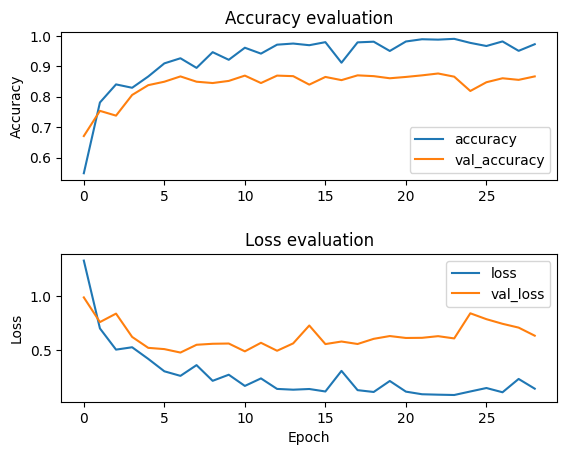

In [ ]:
# plot accuracy/loss for training/validation set as a function of the epochs
plot_history(history1)

In [ ]:
# evaluate network on test set
test_loss, test_acc = model_with_2layers.evaluate(X_test, y_test)
print("\nTest loss: {}, test accuracy: {}".format(test_loss, 100*test_acc))

45/45 [==============================] - 0s 11ms/step - loss: 0.6226 - accuracy: 0.8774

Test loss: 0.6226077079772949, test accuracy: 87.74373531341553


### CNN model with 4 layers

In [ ]:
# create network

#parameters 
LEARNING_RATE = 0.001


def build_model3(input_shape, loss="sparse_categorical_crossentropy", learning_rate=0.0001):
    
    # build network architecture using convolutional layers
    model = tf.keras.models.Sequential()

    # 1st conv layer
    model.add(tf.keras.layers.Conv2D(64, (4, 4), activation='relu', input_shape=input_shape, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((4, 4), strides=(2,2), padding='same'))

    # 2nd conv layer
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))

    # 3rd conv layer
    model.add(tf.keras.layers.Conv2D(32, (2, 2), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2), padding='same'))

    # 4th conv layer
    model.add(tf.keras.layers.Conv2D(16, (1, 1), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((1, 1), strides=(2,2), padding='same'))

    # flatten output and feed into dense layer
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    tf.keras.layers.Dropout(0.3)

    # softmax output layer
    model.add(tf.keras.layers.Dense(8, activation='softmax'))

    optimiser = tf.optimizers.Adam(learning_rate=learning_rate)

    # compile model
    model.compile(optimizer=optimiser,
                  loss=loss,
                  metrics=["accuracy"])

    # print model parameters on console
    model.summary()

    return model

input_shape = (X_train.shape[1], X_train.shape[2], 1)
model_with_4layers = build_model3(input_shape, learning_rate=LEARNING_RATE)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 41, 10, 64)        1088      
                                                                 
 batch_normalization_7 (Batc  (None, 41, 10, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 21, 5, 64)        0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 19, 3, 32)         18464     
                                                                 
 batch_normalization_8 (Batc  (None, 19, 3, 32)        128       
 hNormalization)                                                 
                                                      

In [ ]:
# train network
history2 = train(model_with_4layers, EPOCHS, BATCH_SIZE, PATIENCE, X_train, y_train, X_validation, y_validation)

Epoch 1/40
288/288 [==============================] - 13s 37ms/step - loss: 1.5545 - accuracy: 0.4587 - val_loss: 1.1976 - val_accuracy: 0.5883
Epoch 2/40
288/288 [==============================] - 10s 33ms/step - loss: 1.0147 - accuracy: 0.6673 - val_loss: 0.9712 - val_accuracy: 0.6902
Epoch 3/40
288/288 [==============================] - 9s 31ms/step - loss: 0.7962 - accuracy: 0.7470 - val_loss: 0.8186 - val_accuracy: 0.7589
Epoch 4/40
288/288 [==============================] - 10s 36ms/step - loss: 0.6617 - accuracy: 0.7986 - val_loss: 0.9265 - val_accuracy: 0.7154
Epoch 5/40
288/288 [==============================] - 9s 32ms/step - loss: 0.6160 - accuracy: 0.8147 - val_loss: 0.5976 - val_accuracy: 0.8303
Epoch 6/40
288/288 [==============================] - 9s 32ms/step - loss: 0.5377 - accuracy: 0.8476 - val_loss: 0.6490 - val_accuracy: 0.7972
Epoch 7/40
288/288 [==============================] - 10s 35ms/step - loss: 0.6469 - accuracy: 0.8119 - val_loss: 0.6703 - val_accuracy: 0.

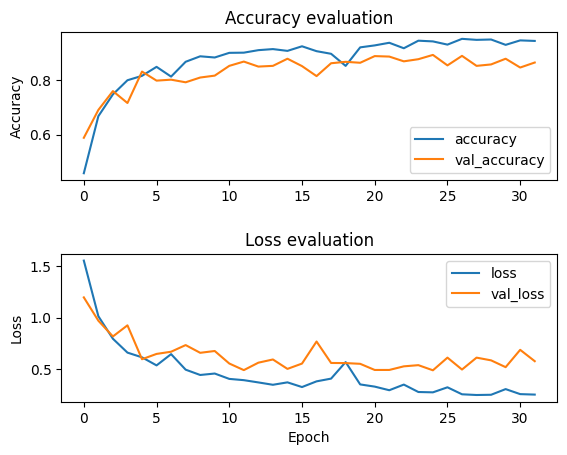

In [ ]:
# plot accuracy/loss for training/validation set as a function of the epochs
plot_history(history2)

In [ ]:
# evaluate network on test set
test_loss, test_acc = model_with_4layers.evaluate(X_test, y_test)
print("\nTest loss: {}, test accuracy: {}".format(test_loss, 100*test_acc))

45/45 [==============================] - 0s 10ms/step - loss: 0.5308 - accuracy: 0.8705

Test loss: 0.5307533740997314, test accuracy: 87.0473563671112


## Experiment with Different learning rate

In [ ]:
from tabulate import tabulate

#Array of different values of learning rate 
lr_array = [0.00001, 0.0001, 0.001, 0.01, 0.1]
result = []

for i in lr_array:
  temp = []
  model = build_model(input_shape, learning_rate=i)
  history = train(model, EPOCHS, BATCH_SIZE, PATIENCE, X_train, y_train, X_validation, y_validation)
  test_loss, test_acc = model.evaluate(X_test, y_test)
  temp.append(i)
  temp.append(test_loss)
  temp.append(test_acc)
  result.append(temp)
  #print("\nFor Learning rate: {} - Test loss: {}, test accuracy: {}".format(i, test_loss, 100*test_acc))


# create header
head = ["Learning Rate", "Test Loss", "Test Accuracy"]
 
# display table
print(tabulate(result, headers=head, tablefmt="grid"))



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 42, 11, 64)        640       
                                                                 
 batch_normalization_11 (Bat  (None, 42, 11, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 21, 6, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 19, 4, 32)         18464     
                                                                 
 batch_normalization_12 (Bat  (None, 19, 4, 32)        128       
 chNormalization)                                                
                                                      

### Experminet with differnt batch size

In [ ]:
from tabulate import tabulate

#Array of different values of learning rate 
batch_array = [16, 32, 64, 128, 256]
result1 = []

for i in batch_array:
  temp = []
  model = build_model(input_shape, learning_rate=LEARNING_RATE)
  history = train(model, EPOCHS, i, PATIENCE, X_train, y_train, X_validation, y_validation)
  test_loss, test_acc = model.evaluate(X_test, y_test)
  temp.append(i)
  temp.append(test_loss)
  temp.append(test_acc)
  result1.append(temp)
  #print("\nFor Learning rate: {} - Test loss: {}, test accuracy: {}".format(i, test_loss, 100*test_acc))


# create header
head1 = ["Batch Size", "Test Loss", "Test Accuracy"]
 
# display table
print(tabulate(result1, headers=head1, tablefmt="grid"))



Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 42, 11, 64)        640       
                                                                 
 batch_normalization_26 (Bat  (None, 42, 11, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 21, 6, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 19, 4, 32)         18464     
                                                                 
 batch_normalization_27 (Bat  (None, 19, 4, 32)        128       
 chNormalization)                                                
                                                      

### Experminet with differnt Epoch value

In [ ]:
from tabulate import tabulate

#Array of different values of learning rate 
epoch_array = [20, 30, 40, 50, 60]
result2 = []

for i in epoch_array:
  temp = []
  model = build_model(input_shape, learning_rate=LEARNING_RATE)
  history = train(model, i, BATCH_SIZE, PATIENCE, X_train, y_train, X_validation, y_validation)
  test_loss, test_acc = model.evaluate(X_test, y_test)
  temp.append(i)
  temp.append(test_loss)
  temp.append(test_acc)
  result2.append(temp)
  #print("\nFor Learning rate: {} - Test loss: {}, test accuracy: {}".format(i, test_loss, 100*test_acc))


# create header
head2 = ["Epoch", "Test Loss", "Test Accuracy"]
 
# display table
print(tabulate(result2, headers=head2, tablefmt="grid"))



Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_65 (Conv2D)          (None, 42, 11, 64)        640       
                                                                 
 batch_normalization_65 (Bat  (None, 42, 11, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_65 (MaxPoolin  (None, 21, 6, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_66 (Conv2D)          (None, 19, 4, 32)         18464     
                                                                 
 batch_normalization_66 (Bat  (None, 19, 4, 32)        128       
 chNormalization)                                                
                                                     

### Experminet with differnt Patience value

In [ ]:
from tabulate import tabulate

#Array of different values of learning rate 
patience_array = [3, 4, 5, 6, 7]
result3 = []

for i in patience_array:
  temp = []
  model = build_model(input_shape, learning_rate=LEARNING_RATE)
  history = train(model, EPOCHS, BATCH_SIZE, i, X_train, y_train, X_validation, y_validation)
  test_loss, test_acc = model.evaluate(X_test, y_test)
  temp.append(i)
  temp.append(test_loss)
  temp.append(test_acc)
  result3.append(temp)
  #print("\nFor Learning rate: {} - Test loss: {}, test accuracy: {}".format(i, test_loss, 100*test_acc))


# create header
head3 = ["Patience", "Test Loss", "Test Accuracy"]
 
# display table
print(tabulate(result3, headers=head3, tablefmt="grid"))



Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_50 (Conv2D)          (None, 42, 11, 64)        640       
                                                                 
 batch_normalization_50 (Bat  (None, 42, 11, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_50 (MaxPoolin  (None, 21, 6, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_51 (Conv2D)          (None, 19, 4, 32)         18464     
                                                                 
 batch_normalization_51 (Bat  (None, 19, 4, 32)        128       
 chNormalization)                                                
                                                     